In [1]:
# Dependencies
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.stats as sts

In [2]:
csv_path = "Resources/videos.csv"
df = pd.read_csv(csv_path)
# df.head(10)

In [3]:
# clean up data before creating dataframe for calculations
df_path = "Resources/videos.csv"
df = pd.read_csv(df_path)

df[["publish date", "asdf"]] = df["publish_time"].str.split(pat="T", n=1, expand=True)


df[["publish time", "trash"]] = df["asdf"].str.split(pat=".", n=1, expand=True)


df["publish date"] = pd.to_datetime(df["publish date"])
df["publish_date"] = df["publish date"].dt.strftime('%m/%d/%Y')


category_json_path = "Resources/US_category_id.json"
category_dict = {'category_id': [], 'Category': []}
indexer = 0

with open(category_json_path) as json_data:
  data = json.load(json_data)

items = data['items']
# items

for item in items:
    
    category_dict['category_id'].append(data['items'][indexer]['id'])
    category_dict['Category'].append(data['items'][indexer]['snippet']['title'])
    indexer = indexer + 1
        


category_df = pd.DataFrame(category_dict)
category_df["category_id"] = category_df["category_id"].astype(int)
df = df.merge(category_df, how='inner', on='category_id')



df["trending_date"]=pd.to_datetime(df["trending_date"].astype(str), format="%y.%d.%m")
df["trending_date"] = df["trending_date"].dt.strftime("%m/%d/%Y")
# df.head()

In [4]:
# clean up data frame for only columns we want to work with
df = df[["video_id", "title", "channel_title", "Category", "publish time", "publish_date", "trending_date", "views", "likes", "dislikes", "tags", "comments_disabled"]]
# df.head()

In [5]:
# data frame with rows for last trending date
last_df = df[['video_id', 'trending_date']]
last_df = last_df.groupby('video_id').max()
last_df = last_df.reset_index()
last_df = last_df.merge(df, how ='left')
last_df.head()

,video_id,trending_date,title,channel_title,Category,publish time,publish_date,views,likes,dislikes,tags,comments_disabled
0,-0CMnp02rNY,06/11/2018,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,Entertainment,13:00:00,06/04/2018,800359,9773,332,"ellen|""ellen degeneres""|""the ellen show""|""elle...",False
1,-0NYY8cqdiQ,02/01/2018,Megan Mullally Didn't Notice the Interesting P...,TheEllenShow,Entertainment,14:00:39,01/29/2018,563746,4429,54,"megan mullally|""megan""|""mullally""|""will and gr...",False
2,-1Hm41N0dUs,05/01/2018,Cast of Avengers: Infinity War Draws Their Cha...,Jimmy Kimmel Live,Comedy,07:30:02,04/27/2018,2058516,41248,580,"jimmy|""jimmy kimmel""|""jimmy kimmel live""|""late...",False
3,-1yT-K3c6YI,12/02/2017,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,Molly Burke,People & Blogs,18:30:43,11/28/2017,231341,7734,212,"youtube quiz|""youtuber quiz""|""truth or dare""|""...",False
4,-2RVw2_QyxQ,11/16/2017,2017 Champions Showdown: Day 3,Saint Louis Chess Club,Education,02:39:01,11/12/2017,71089,460,27,"Chess|""Saint Louis""|""Club""",False


In [6]:
# data frame with rows for first trending date
first_df = df[['video_id', 'trending_date']]
first_df = first_df.groupby('video_id').min()
first_df = first_df.reset_index()
first_df = first_df.merge(df, how ='left')
# first_df.head()

In [7]:
# Mike's Code

# VISUALIZATION 5: popular tags on YouTube videos

# need to split the tags for each video into a new DataFrame in order to graph the bar chart
# empty lists to store video_id & tags within for loops below
tags_ = []
ids = []

# put tags into new list, split on "|"
for _, row in first_df.iterrows():
    current_tags = row["tags"].split("|")
    
    # for every video, all tags except the first one have quotation marks
    # remove quotes by slicing the first and last character of each entry, starting with the 2nd one (index=1)
    for i in range(1, len(current_tags)):
        current_tags[i] = current_tags[i][1:-1]
    
    # push the clean entries into each list
    for tag in current_tags:
        tags_.append(tag)
        ids.append(row["video_id"])

# create new dataframe with the clean entries, using video_id as the index
video_tags = pd.DataFrame({"video_id": ids, "tags": tags_})
# video_tags

In [8]:
video_tags["tags"].nunique()

56163

In [9]:
## Mike's Code

In [10]:
# Riley's Code

In [11]:
# Split the Publish time column by the hour, convert to integer

publish_df = last_df
publish_df[["publish_hour", "publish_min_sec"]] = publish_df["publish time"].str.split(":", n=1, expand=True)
publish_df['publish_hour'] = publish_df['publish_hour'].astype(int)
# publish_df.head()

# New DF grouped by the publish hour

publish_group_df = publish_df.groupby('publish_hour').count()
publish_group_df = publish_group_df['video_id']
# publish_group_df

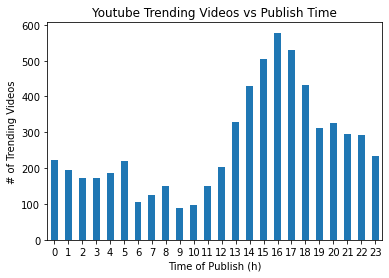

In [12]:
# Plot # of trending videos by publish time

publish_group_df.plot(kind='bar', rot = 0)

plt.xlabel('Time of Publish (h)')
plt.ylabel('# of Trending Videos')
plt.title('Youtube Trending Videos vs Publish Time')
plt.show()

In [ ]:
# Summary table for time to trend

trend_df = first_df
trend_df['trending_date'] = pd.to_datetime(trend_df['trending_date'])
trend_df['publish_date'] = pd.to_datetime(trend_df['publish_date'])
trend_df['Days to Trend'] = trend_df['trending_date'] - trend_df['publish_date']

max_trend = str(trend_df['Days to Trend'].max())
max_trend_list = max_trend.split(' ')
max_trend_video = trend_df.iloc[trend_df['Days to Trend'].idxmax(),2]

min_trend = str(trend_df['Days to Trend'].min())
min_trend_list = min_trend.split(' ')

mean_trend = str(trend_df['Days to Trend'].mean().round('d'))
mean_trend_list = mean_trend.split(' ')

med_trend = str(trend_df['Days to Trend'].median())
med_trend_list = med_trend.split(' ')

std_trend = str(trend_df['Days to Trend'].std().round('d'))
std_trend_list = std_trend.split(' ')

# Put into DataFrame
trending_summary_df = pd.DataFrame({'Statistic':['Maximum', 'Minimum', 'Mean', 'Median', 'Standard Deviation'],
                                    'Days': [max_trend_list[0], min_trend_list[0], mean_trend_list[0], med_trend_list[0], std_trend_list[0]]
                                   })
trending_summary_df

In [27]:
# Remove outliers for box plot
trend_df['Days to Trend'] = trend_df['Days to Trend'].strftime()

# days = trend_df['Days to Trend']
# quartiles = days.quantile([.25,.5,.75])
# lowerq = quartiles[0.25]
# upperq = quartiles[0.75]
# iqr = upperq-lowerq

# print(f"The lower quartile of days is: {lowerq}")
# print(f"The upper quartile of days is: {upperq}")
# print(f"The interquartile range of days is: {iqr}")
# print(f"The the median of days is: {quartiles[0.5]} ")

# lower_bound = lowerq - (1.5*iqr)
# upper_bound = upperq + (1.5*iqr)
# print(f"Values below {lower_bound} could be outliers.")
# print(f"Values above {upper_bound} could be outliers.")

# plt.boxplot(trend_df['Days to Trend'])
# plt.show()
trend_df.head()

,video_id,trending_date,title,channel_title,Category,publish time,publish_date,views,likes,dislikes,tags,comments_disabled,Days to Trend
0,-0CMnp02rNY,2018-06-06,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,Entertainment,13:00:00,2018-06-04,475965,6531,172,"ellen|""ellen degeneres""|""the ellen show""|""elle...",False,2 days 00:00:00.000000000
1,-0NYY8cqdiQ,2018-02-01,Megan Mullally Didn't Notice the Interesting P...,TheEllenShow,Entertainment,14:00:39,2018-01-29,563746,4429,54,"megan mullally|""megan""|""mullally""|""will and gr...",False,3 days 00:00:00.000000000
2,-1Hm41N0dUs,2018-04-29,Cast of Avengers: Infinity War Draws Their Cha...,Jimmy Kimmel Live,Comedy,07:30:02,2018-04-27,1566807,32752,393,"jimmy|""jimmy kimmel""|""jimmy kimmel live""|""late...",False,2 days 00:00:00.000000000
3,-1yT-K3c6YI,2017-11-29,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,Molly Burke,People & Blogs,18:30:43,2017-11-28,129360,5214,108,"youtube quiz|""youtuber quiz""|""truth or dare""|""...",False,1 days 00:00:00.000000000
4,-2RVw2_QyxQ,2017-11-14,2017 Champions Showdown: Day 3,Saint Louis Chess Club,Education,02:39:01,2017-11-12,67429,438,23,"Chess|""Saint Louis""|""Club""",False,2 days 00:00:00.000000000


In [14]:
## Riley's Code

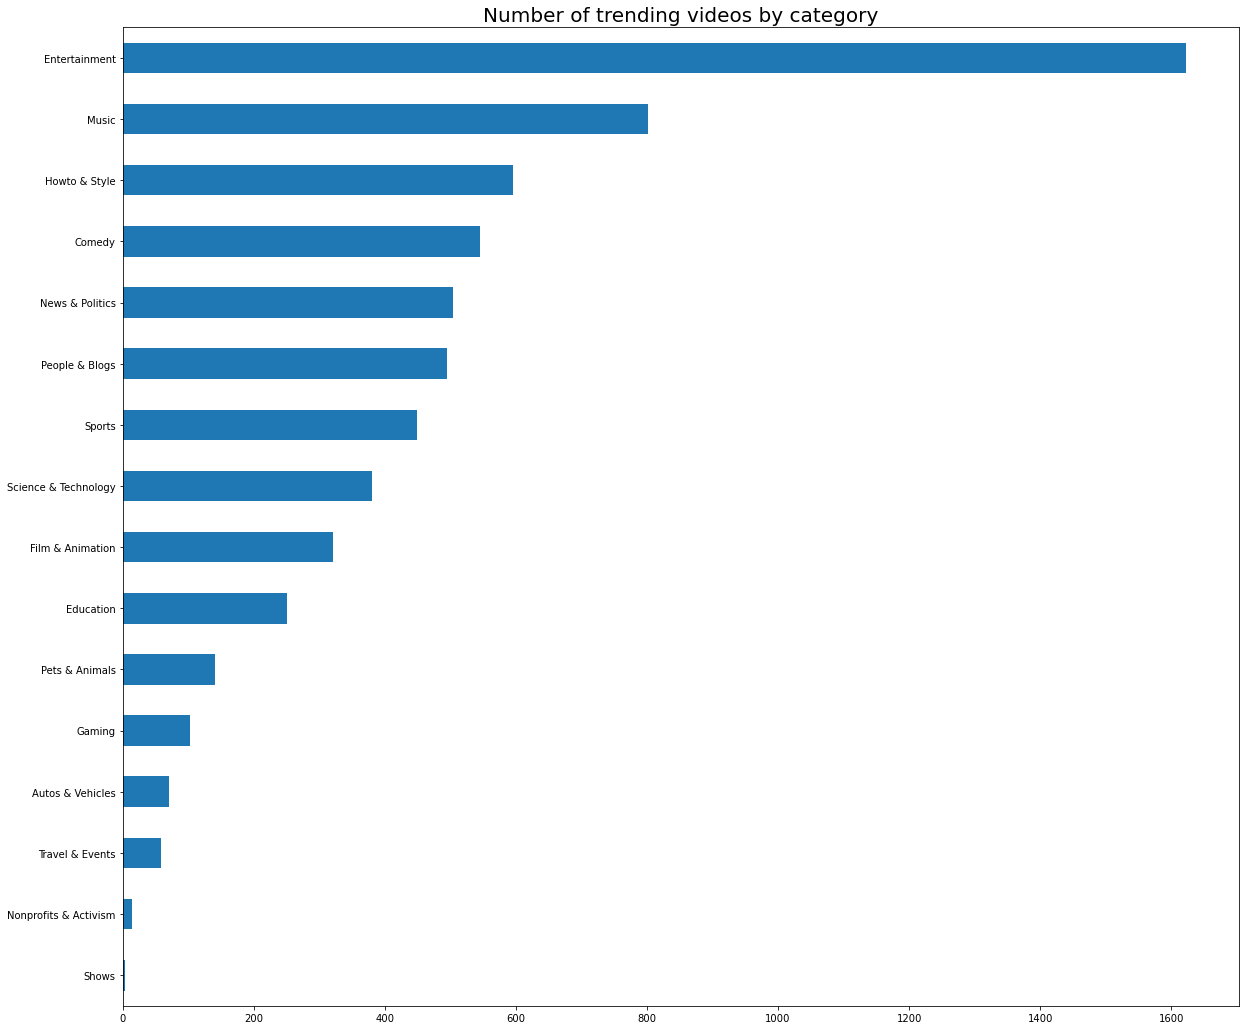

,views,likes,dislikes,publish_hour
count,6.354000e+03,6.354000e+03,6.354000e+03,6354.000000
mean,1.953425e+06,5.544250e+04,3.052799e+03,13.517155
std,7.047588e+06,1.936551e+05,3.197244e+04,6.493851
min,5.590000e+02,0.000000e+00,0.000000e+00,0.000000
25%,1.566798e+05,2.749250e+03,1.260000e+02,9.000000
50%,5.141285e+05,1.184150e+04,4.410000e+02,15.000000
75%,1.458180e+06,3.841925e+04,1.491000e+03,18.000000
max,2.252119e+08,5.613827e+06,1.674420e+06,23.000000


In [15]:
# Jackie's Code

## How many videos have gone trending per Category? (Bar Chart)
last_df['Category'].value_counts().sort_values().plot(kind='barh', figsize=(20,18))
plt.title("Number of trending videos by category", size=20)
plt.show()

## Statistical Summary
last_df.describe()

In [16]:
## Convert to floats and store views and likes as x and y values
x_values = last_df['views'].astype('float')
y_values = last_df['dislikes'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.xlabel('Number of Views')
plt.ylabel('Number of Dislikes')
plt.title("Number of Dislikes by View", size=15)

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()

NameError: name 'linregress' is not defined

In [ ]:
## Convert to floats and store views and likes as x and y values
x_values = last_df['views'].astype('float')
y_values = last_df['likes'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = sts.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.xlabel('Number of Views')
plt.ylabel('Number of Likes')
plt.title("Number of Likes by View", size=15)

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()

# Generate the correlation matrix and find the strongest positive and negative correlations
videos_corr = last_df.corr()
videos_corr.unstack().sort_values()



In [ ]:
## Jackie's Code

In [ ]:
# Brian's Code

In [ ]:
# Generate a bar plot showing the top 20 youtube channels with most trending videos.

# groupby video_id using count and channel_title
vids_per_title_df = last_df[["video_id", "channel_title"]]
# vids_per_title_df.head()

vids_per_title_df = vids_per_title_df.groupby("channel_title").count()
# len(vids_per_title_df)
# vids_per_title_df.head()

vids_per_title_df = vids_per_title_df.sort_values(by = 'video_id', ascending = False)
# vids_per_title_df.head()

# plot a bar chart
# vids_per_title_df.head(20).plot(kind="bar", figsize=(12,8), color = "b", legend=False)
vids_per_title_df.head(20).plot(kind="bar", figsize=(12,8), color = [plt.cm.Paired(np.arange(len(vids_per_title_df)))], legend=False)

# title
plt.title("Top Twenty YouTube Channels With Most Trending Videos")
plt.xticks(rotation=45, horizontalalignment="right")
plt.xlabel("YouTube Channels")
plt.ylabel("Number of Trending Videos")

plt.show()
# plt.tight_layout()

In [ ]:
## Brian's code